# **Estudios con Frozen Lake**

_Esto es un ejemplo de uso de Gymnasium e informe sobre un experimento de aprendizaje por refuerzo_

````
José María García, Ana Gil, Levi Malest
````

Este notebook describe varios experimentos de aprendizaje por refuerzo utilizando el algoritmo de Monte Carlo con políticas epsilon-soft, tanto on-policy como off-policy, así como el algoritmo SARSA y el Q-learning. El propósito de este análisis es entrenar un agente en un entorno de gym con el juego "FrozenLake", un entorno estándar en el que el agente debe aprender a moverse a través de un mapa en busca de una meta, evitando caer en agujeros. A continuación, se presenta una descripción de las diferentes partes del código y el proceso utilizado en el experimento.

## **1. Preparación del Entorno**

La preparación consta de las siguientes partes:
- **Instalación de Dependencias**: Se instalan las librerías necesarias para utilizar el entorno `gymnasium` para la simulación, con el objetivo de crear un ambiente controlado para que el agente pueda interactuar.
- **Importación de Librerías**: Se importan las bibliotecas necesarias como `numpy` para el manejo de matrices y `matplotlib` para la visualización de los resultados.

- **Importación del Entorno "FrozenLake"**:
Se cargan dos versiones del entorno "FrozenLake": una de 4x4 y otra de 8x8. Ambas versiones no son resbaladizas, lo que facilita la comprensión de los resultados, dado que el entorno resbaladizo podría dificultar la comprensión inicial del aprendizaje.

#### 3. **Funciones para Mostrar los Resultados**
   - Se define una función para graficar la proporción de recompensas obtenidas en cada episodio del entrenamiento. Esto ayuda a visualizar el progreso del agente en términos de su desempeño durante el entrenamiento.



##### _________ **Código de la Instalación e Importación**
----

In [53]:
%%capture
#@title Instalamos gym
!pip install 'gym[box2d]==0.20.0'

## Instalación de algunos paquetes.
#!apt-get update
## Para usar gymnasium[box2d]
#!apt install swig
#!pip install gymnasium[box2d]

In [54]:
#@title Importamos librerias
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gymnasium as gym
from gymnasium.wrappers import TimeLimit

In [55]:
#@title Importamos el lago helado
name = 'FrozenLake-v1'
env4 = gym.make(name, is_slippery=False, map_name="4x4", render_mode="ansi") # No resbaladizo para entender mejor los resultados.
env8 = gym.make(name, is_slippery=False, map_name="8x8", render_mode="ansi") # No resbaladizo para entender mejor los resultados.

In [56]:
#@title Copiar el repositorio ``JMGO-coding/RL_GGM``.

!git clone https://github.com/JMGO-coding/RL_GGM.git
!cd RL_GGM/

fatal: destination path 'RL_GGM' already exists and is not an empty directory.


In [57]:
#@title Importamos todas las clases y funciones

import sys

# Añadir los directorio fuentes al path de Python
sys.path.append('/content/RL_GGM')
sys.path.append('/content/RL_GGM/src')

# Verificar que se han añadido correctamente
print(sys.path)

from agents import Agent, AgentMCOnPolicyAllVisits, AgentMCOffPolicyAllVisits, AgentSARSA, AgentQLearning
from policies import EpsilonSoftPolicy, GreedyFromQPolicy
from wrappers import FrozenLakeCustomRewards

['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/root/.ipython', '/content/RL_GGM', '/content/RL_GGM/src', '/usr/local/lib/python3.11/dist-packages/setuptools/_vendor', '/content/RL_GGM', '/content/RL_GGM/src']


In [58]:
import os
import gc
import torch
import numpy as np
import gymnasium as gym

# Configuración del dispositivo (CPU o GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Liberación de memoria para evitar problemas de consumo en GPU
gc.collect() # Ejecuta el recolector de basura de Python
torch.cuda.empty_cache() # Vacía la caché de memoria en GPU

# Depuración de errores en CUDA
os.environ['CUDA_LAUNCH_BLOCKING'] = '1' # Muestra errores de CUDA en el punto exacto donde ocurren

# Configuración de la semilla para reproducibilidad
seed = 2024 # Se define una semilla fija

# Fijar la semilla en NumPy
np.random.seed(seed) # Para generar números aleatorios consistentes en NumPy
np.random.default_rng(seed) # Establece una instancia del generador de NumPy con la misma semilla

# Fijar la semilla en Python
os.environ['PYTHONHASHSEED'] = str(seed) # Evita variabilidad en hashing de Python

# Fijar la semilla en PyTorch
torch.manual_seed(seed) # Asegura resultados reproducibles en operaciones de PyTorch

if torch.cuda.is_available(): # Si hay GPU disponible
    torch.cuda.manual_seed(seed) # Fija la semilla para la GPU
    torch.backends.cudnn.deterministic = True # Hace las operaciones de CUDNN determinísticas
    torch.backends.cudnn.benchmark = False # Desactiva optimizaciones de CUDNN para evitar variabilidad

# Fijar la semilla en Gymnasium
def make_env(env_name):
    env = gym.make(env_name)
    env.reset(seed=seed) # Establece la semilla en el entorno de Gymnasium
    return env

# Ejemplo de creación de un entorno con semilla
env_name = 'FrozenLake-v1' # Cambiar según el entorno deseado
env = make_env(env_name)

env4.reset(seed=seed)
env8.reset(seed=seed)

Usando dispositivo: cpu


(0, {'prob': 1})

## **2. Diseño del Agente**

El diseño del agente consta de dos partes, el algoritmo con el que aprende y las políticas (toma de decisiones) que realiza.

- **Políticas del Agente**
   - **Política epsilon-soft**: Se define una política donde todas las acciones tienen una probabilidad de ser elegida.
   - **Política epsilon-greedy**: basada en la política epsilon-soft. De esta forma el agente tiene una pequeña probabilidad de explorar (tomar una acción aleatoria) y una mayor probabilidad de explotar (tomar la acción que considera mejor). Esto permite equilibrar la exploración y la explotación.
   - **Política greedy**: Es la usada una vez que "ha aprendido".

- **Algoritmo de Iteración de Valor**
  - Se implementa el algoritmo de iteración de valor utilizando Monte Carlo.
  - Se usa una versión "on-policy" de Monte Carlo con políticas epsilon greedy sobre una política epsilon-soft.
  - Se basa en el criterio de todas las visitas.
  - Otro aspecto es que la actualización de los retornos no se realiza en el orden inverso a las visitas.

#### **Código de las políticas y algoritmo MC**
----------------

Nota: Aunque las siguientes funciones no se utilizan en la implementación final, las dejamos aquí como referencia, ya que representan la lógica interna que ahora está encapsulada dentro de la clase del agente. Solo mostramos estas funciones para el algoritmo Monte Carlo on-policy como ejemplo. Con el resto de algoritmos pasaremos directamente a usar los agentes desde GitHub.

In [59]:
# @title Políticas del agente

# actions
LEFT, DOWN, RIGHT, UP = 0,1,2,3

# Política epsilon-soft. Se usa para el entrenamiento
def random_epsilon_greedy_policy(Q, epsilon, state, nA):
    pi_A = np.ones(nA, dtype=float) * epsilon / nA
    best_action = np.argmax(Q[state])
    pi_A[best_action] += (1.0 - epsilon)
    return pi_A

# Política epsilon-greedy a partir de una epsilon-soft
def epsilon_greedy_policy(Q, epsilon, state, nA):
    pi_A = random_epsilon_greedy_policy(Q, epsilon, state, nA)
    return np.random.choice(np.arange(nA), p=pi_A)

# Política Greedy a partir de los valores Q. Se usa para mostrar la solución.
def pi_star_from_Q(env, Q):
    done = False
    pi_star = np.zeros([env.observation_space.n, env.action_space.n])
    state, info = env.reset() # start in top-left, = 0
    actions = ""
    while not done:
        action = np.argmax(Q[state, :])
        actions += f"{action}, "
        pi_star[state,action] = 1
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
    return pi_star, actions

In [60]:
#@title Algoritmo de Iteración de Valor versión MC con Políticas epsilon-soft

def on_policy_all_visit(env, num_episodes=5000, epsilon=0.4, decay=False, discount_factor=1):
    # Matriz de valores Q
    nA = env.action_space.n
    Q = np.zeros([env.observation_space.n, nA])

    # Número de visitas y acumulación de retornos
    n_visits = np.zeros([env.observation_space.n, env.action_space.n])
    returns = np.zeros([env.observation_space.n, env.action_space.n])

    # Para mostrar la evolución en el terminal
    stats = 0.0
    list_stats = [stats]
    step_display = num_episodes / 10

    # Para cada episodio
    for t in tqdm(range(num_episodes)):
        state, info = env.reset(seed=100)
        done = False
        episode = []

        # Generar un episodio siguiendo la política epsilon-soft
        while not done:
            if decay:
                epsilon = min(1.0, 1000.0/(t+1))
            action = epsilon_greedy_policy(Q, epsilon, state, nA)
            new_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            episode.append((state, action, reward))  # Almacenar estado, acción y recompensa
            state = new_state

        G = 0.0  # Retorno
        # Recorrer el episodio en orden inverso
        for (state, action, reward) in reversed(episode):
            G = discount_factor * G + reward
            n_visits[state, action] += 1  # Contamos cuántas veces hemos visitado (state, action)
            returns[state, action] += G  # Acumulamos los retornos

            # Usamos el promedio de los retornos observados
            Q[state, action] = returns[state, action] / n_visits[state, action]

        # Guardamos datos sobre la evolución
        stats += G
        list_stats.append(stats/(t+1))

        # Para mostrar la evolución. Comentar si no se quiere mostrar
        if t % step_display == 0 and t != 0:
            print(f"success: {stats/t}, epsilon: {epsilon}")

    return Q, list_stats

## **3. Preparación del entorno para grabar episodios de Gymnasium**

### Instalación de paquetes

In [61]:
# Instalación de algunos paquetes.
!apt-get update

# Para visualizar en colab https://medium.com/@coldstart_coder/visually-rendering-python-gymnasium-in-jupyter-notebooks-4413e4087a0f
!apt-get install -y python-opengl ffmpeg
!apt-get install --upgrade cmake

# Para usar gymnasium[box2d]
!apt install swig xvfb
!pip install -U  pyvirtualdisplay

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

In [62]:
!pip install gymnasium gymnasium[box2d]

### Creando pantallas virtuales

In [63]:
## Para visualizar en colab https://medium.com/@coldstart_coder/visually-rendering-python-gymnasium-in-jupyter-notebooks-4413e4087a0f
## https://medium.com/@coldstart_coder/dqn-algorithm-training-an-ai-to-land-on-the-moon-1a1307748ed9
# create a virtual display that will hold our video

# Google Colab se ejecuta en un entorno de servidor sin una interfaz gráfica de
# usuario (GUI). Para mostrar contenido visual como videos, se necesita una
# pantalla virtual para simular una pantalla.
# Esto permite que bibliotecas como gymnasium rendericen gráficos
# y los capturen para incrustarlos en el notebook.
#
# Este código crea una pantalla virtual oculta donde se puede renderizar contenido gráfico.

# pyvirtualdisplay es una biblioteca se usa para crear pantallas virtuales,
# que son esenciales para renderizar contenido gráfico en entornos sin interfaz gráfica.
from pyvirtualdisplay import Display

# visible=0 indica que la pantalla estará oculta (no visible para el usuario).
# Esto se debe a que Colab se ejecuta en un entorno de servidor sin una interfaz gráfica.
# size=(1400, 900) establece la resolución de la pantalla virtual a 1400x900 píxeles.
display = Display(visible=0, size=(1400, 900))

# inicia la pantalla virtual, preparándola para su uso.
display.start()


# Las siguientes líneas importan las bibliotecas necesarias para trabajar
# con entrada/salida, codificación base64 (usada para incrustar datos de video)
# y mostrar contenido HTML dentro del notebook de Colab.
import io
import base64
from IPython import display
from IPython.display import HTML

# Esta función mostrará un vídelo en la pantalla virtual, que será embembida en el notbook
def embed_video(video_file):
    # open and read the raw data from the video
    video_data = io.open(video_file, 'r+b').read()
    # now we have to encode the data into base64 to work
    # with the virtual display
    encoded_data = base64.b64encode(video_data)
    # now we use the display.display function to take some html
    # and the encoded data and embed the html into the notebook!
    display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                </video>'''.format(encoded_data.decode('ascii'))))

### Para crear y mostrar  los vídeos generados

In [64]:
import re # Para trabajar con expresiones regulares
import os # Para manipular archivos, directorios, variables de entorno y ejecutar comandos del SO

# Define la carpeta donde se guardarán los vídeos
video_folder = "videos"  # Nombre de la carpeta (puedes cambiarlo)

# Crea la carpeta si no existe
os.makedirs(video_folder, exist_ok=True) # exist_ok=True evita error si ya existe

# Retorna el nombre del último vídeo generado

def get_latest_episode_video_file(directory):
    # Expresión regular que coincide con el formato de los ficheros de video
    pattern = re.compile(r"rl-video-episode-(\d+)\.mp4")
    latest_file = None
    highest_episode = -1

    # Busca en el directorio
    for filename in os.listdir(directory):
        match = pattern.match(filename)
        if match:
            episode_number = int(match.group(1))  # Extrae el número de episodio
            # Comprobamos, para conseguir el número de episodio más alto.
            if episode_number > highest_episode:
                highest_episode = episode_number
                latest_file = os.path.join(directory, filename)  # Almacena el path completo

    return latest_file

### **Representaciones Gráficas**

Para comprobar el aprendizaje se mostrará la función $f(t)=\frac{\sum_{i=1}^t R_i}{t}$ para $t=1,2,\ldots, NumeroEpisodios$. La justificación es la siguiente. Como sabemmos que el retorno en el estados inicial 1 (pues no hay descuento) o 9, si se divide por el número de episodios ejecutados se calcular el porcentaje de recompensas positivas obtenidas. Dicho de otra forma, nos dirá el porcentaje de veces que el agente ha llegado al estado terminal.

También se muestra una gráfica con la longitud de los episodios en cada estado. Esta gráfica nos será útil para analizar si realmente el algoritmo está aprendiendo a llegar a la meta en cada episodio, observando cómo evoluciona la duración de los episodios a lo largo del entrenamiento (lo ideal sería que vayan disminuyendo conforme vaya aprendiendo).

In [65]:
# @title Funciones para mostrar los resultados

def plot(list_stats):
  # Creamos una lista de índices para el eje x
  indices = list(range(len(list_stats)))

  # Creamos el gráfico
  plt.figure(figsize=(15, 8))
  plt.plot(indices, list_stats)

  # Añadimos título y etiquetas
  plt.title('Proporción de recompensas')
  plt.xlabel('Episodio')
  plt.ylabel('Proporción')

  # Mostramos el gráfico
  plt.grid(True)
  plt.show()

# Función para mostrar el tamaño de los episodios
def plot_episode_lengths(episode_lengths):
    """
    Grafica la longitud de los episodios
    """
    # Creamos una lista de índices para el eje x (número de episodios)
    indices = list(range(len(episode_lengths)))

    # Creamos el gráfico
    plt.figure(figsize=(15, 8))
    plt.plot(indices, episode_lengths)

    # Añadimos título y etiquetas
    plt.title('Longitud de los Episodios')
    plt.xlabel('Episodio')
    plt.ylabel('Longitud del Episodio')

    # Mostramos el gráfico
    plt.grid(True)
    plt.show()

# Histograma con la longitud de los episodios
def plot_episode_lengths_histogram(episode_lengths, bins=20):
    """
    Muestra un histograma de la frecuencia de las longitudes de episodios
    """
    plt.figure(figsize=(15, 8))
    plt.hist(episode_lengths, bins=bins, alpha=0.75, color='blue', edgecolor='black')

    plt.title('Distribución de la Longitud de los Episodios')
    plt.xlabel('Longitud del Episodio')
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.show()

## **4. Monte Carlo on-policy**

   - En esta sección, el algoritmo de Monte Carlo on-policy con la política epsilon-soft se ejecuta tanto para el entorno de 4x4 como al de 8x8 de FrozenLake sin resbalar.
   
   - En ambos casos se realiza un entrenamiento con un número determinado de episodios (50000 en concreto)

   - Además en el escenario 8x8 el  epsilon tiene decaimiento de acuerdo a la expresión: $\epsilon = min(1.0, 1000.0/(t+1))$

   - Durante el entrenamiento hay una visualización de la proporción de recompensas obtenidas a lo largo del entrenamiento.

   - Junto a dicho volcado se muestra gráficamente la proporcion de recompensas obtendias.

   - También se hace un volcado de los valores Q de cada estado, donde se muestra cómo el agente valora diferentes acciones en distintos estados del entorno, lo que puede interpretarse como su conocimiento sobre las mejores estrategias para alcanzar la meta sin caer en los agujeros.

   - Además, se muestra la política óptima derivada de los valores Q. Esta política es la que el agente seguiría si tuviera que elegir siempre la acción que maximiza su recompensa esperada.

   

### **4.1 Experimentación en el escenario 4x4**



   - Se realizan 50000 episodios y se actualizan los valores Q (valor de acción) basándose en las recompensas obtenidas durante cada episodio completo (e.d. aplicamos Monte Carlo) Se aplica una política $\epsilon$ greedy sobre una política $\epsilon$ soft con un valor $\epsilon$ constante




In [66]:
# @title Aprendizaje
agent = AgentMCOnPolicyAllVisits(env4, epsilon=0.4, decay=False, discount_factor=1)
agent.reset()
agent.train(num_episodes=50000)

# Estadísticos
list_stats, episode_lengths = agent.get_stats()

 10%|█         | 5100/50000 [00:08<01:07, 664.34it/s]

success: 0.392, epsilon: 0.4


 20%|██        | 10180/50000 [00:14<00:33, 1205.69it/s]

success: 0.4596, epsilon: 0.4


 31%|███       | 15297/50000 [00:17<00:18, 1909.82it/s]

success: 0.4846666666666667, epsilon: 0.4


 41%|████      | 20372/50000 [00:20<00:14, 2006.69it/s]

success: 0.4966, epsilon: 0.4


 51%|█████     | 25378/50000 [00:24<00:13, 1781.17it/s]

success: 0.50312, epsilon: 0.4


 61%|██████    | 30335/50000 [00:27<00:12, 1546.12it/s]

success: 0.5076333333333334, epsilon: 0.4


 71%|███████   | 35286/50000 [00:30<00:07, 1841.48it/s]

success: 0.5112857142857142, epsilon: 0.4


 81%|████████  | 40363/50000 [00:32<00:05, 1923.74it/s]

success: 0.51325, epsilon: 0.4


 91%|█████████ | 45374/50000 [00:35<00:02, 2012.00it/s]

success: 0.5154666666666666, epsilon: 0.4


100%|██████████| 50000/50000 [00:38<00:00, 1300.38it/s]


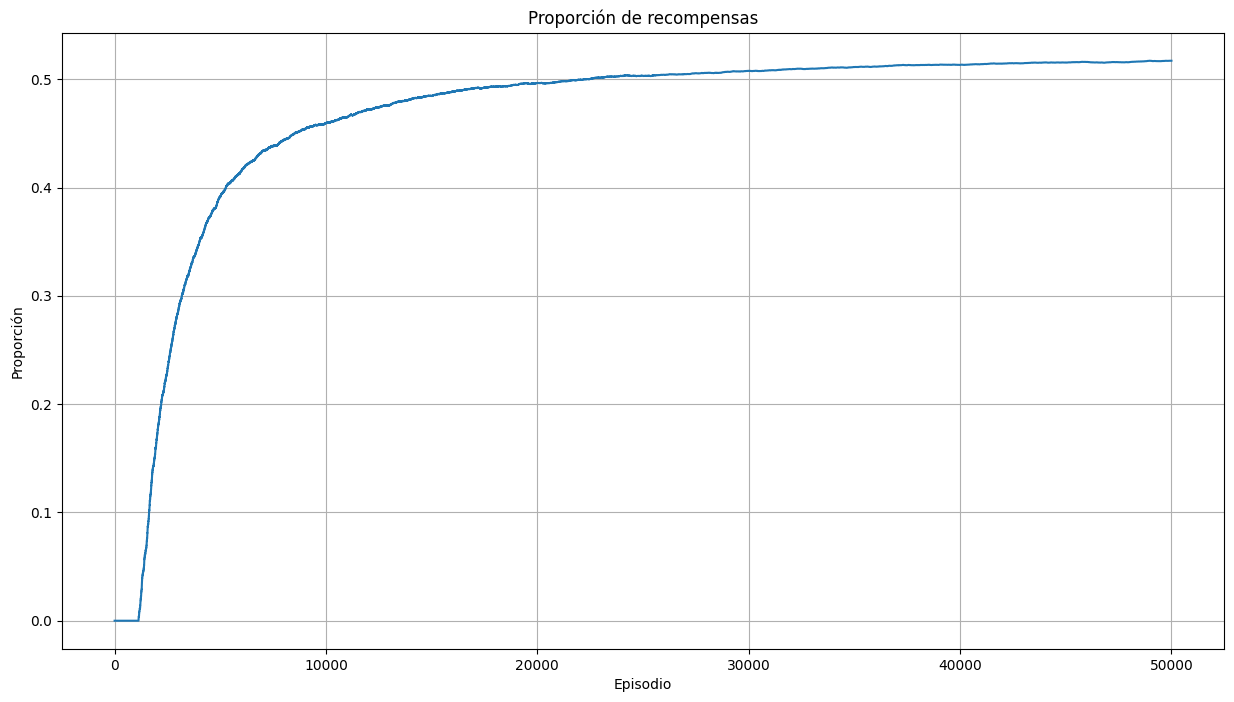

Máxima proporcion: 0.51708


In [67]:
#@title Proporción de aciertos por número de episodios

plot(list_stats)
print(f"Máxima proporcion: {list_stats[-1]}")

En la gráfica de proporción de recompensas se observa como dicha proporción va aumentando con los episodios, lo cual es indicativo de que el agente está aprendiendo a lo largo del entrenamiento.

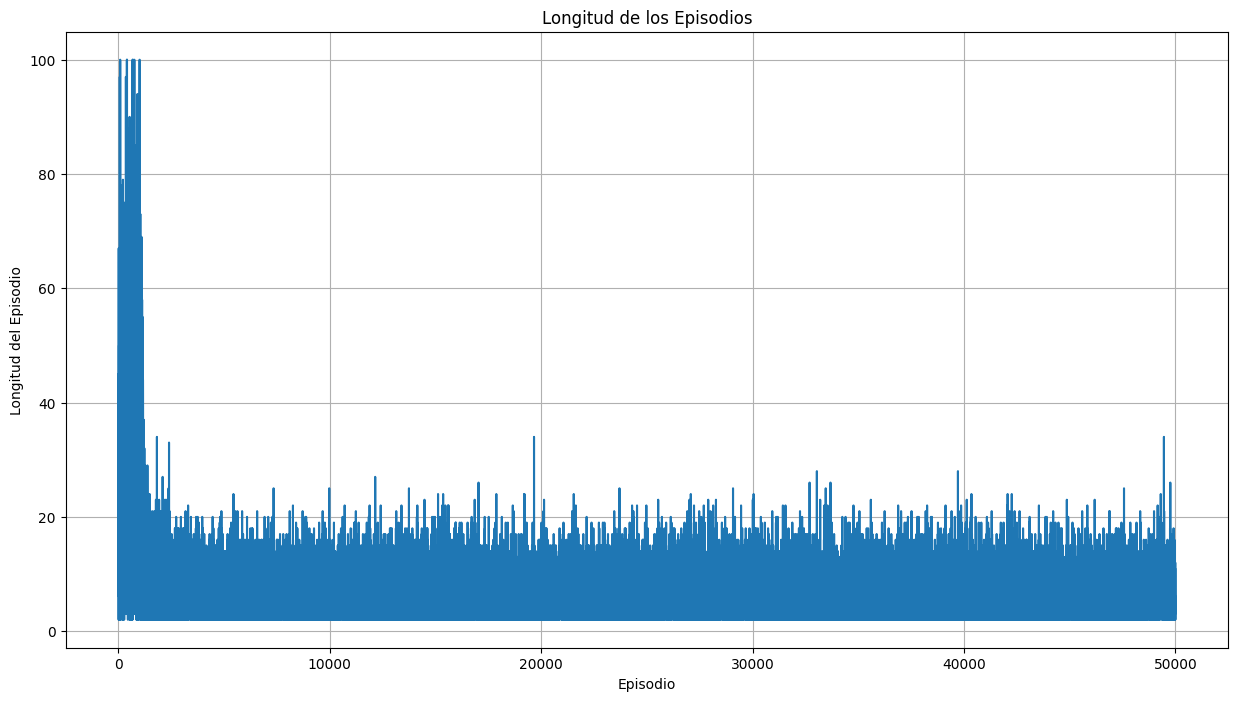

In [68]:
#@title Longitud de los episodios

plot_episode_lengths(episode_lengths)

Observando la gráfica con la longitud de los episodios, se puede apreciar que en los primeros episodios dicha longitud es mayor, pero a lo largo del entrenamiento va disminuyendo, lo cual indica que el agente está aprendiendo a llegar a la meta en menos pasos.

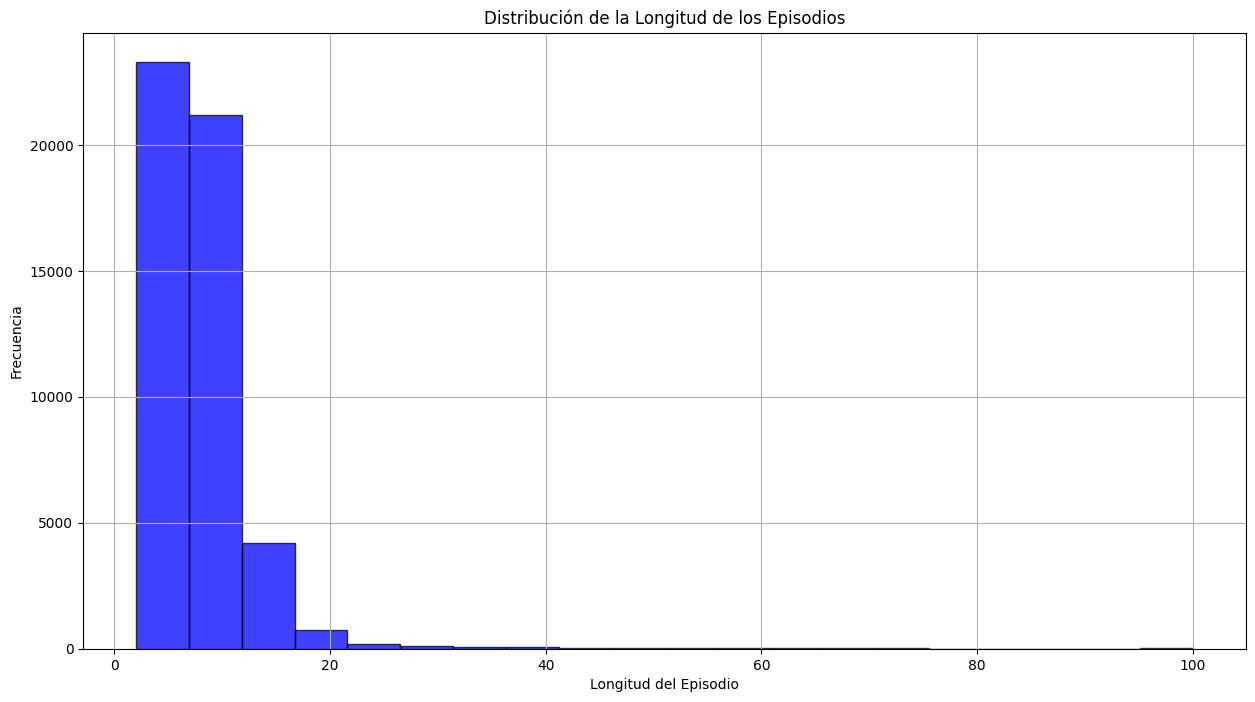

In [69]:
#@title Histograma con la longitud de los episodios

plot_episode_lengths_histogram(episode_lengths)

Mirando el gráfico con la longitud de los episodios, vemos que la mayoría están alrededor de unos 5 o 10 pasos aproximadamente, ya que conforme el agente va aprendiendo, se va disminuyendo dicha longitud al descubrir caminos más cortos para llegar a la meta.


Mostramos los valores Q para cada estado. Cada estado tiene 4 valores, que se corresponden con las 4 acciones que se pueden tomar en cada estado.

In [70]:
# @title Tabla de valores Q
LEFT, DOWN, RIGHT, UP = 0,1,2,3
print("Valores Q para cada estado:\n", agent.Q)

Valores Q para cada estado:
 [[0.2050065  0.44935839 0.50846216 0.43751488]
 [0.42341878 0.         0.59979636 0.47805643]
 [0.50709588 0.62455826 0.51349481 0.59604568]
 [0.59017697 0.         0.50253807 0.46722846]
 [0.09514087 0.56322175 0.         0.31451613]
 [0.         0.         0.         0.        ]
 [0.         0.80652673 0.         0.60178571]
 [0.         0.         0.         0.        ]
 [0.18919873 0.         0.6888361  0.36206897]
 [0.48870968 0.8246516  0.77286136 0.        ]
 [0.71137189 0.95835706 0.         0.6295977 ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.82704918 0.95725102 0.72094926]
 [0.81586095 0.95923988 1.         0.80406705]
 [0.         0.         0.         0.        ]]


- También se muestra la política óptima (greedy) obtenida a partir del aprendizaje anterior.

- Cada estado tienen 4 valores, pero todos son 0 menos 1. Es decir, en cada estado se aplica de manera determinística una única acción.

In [71]:
# @title Política final
LEFT, DOWN, RIGHT, UP = 0,1,2,3
greedy_policy = GreedyFromQPolicy(env4, agent.Q)
pi = greedy_policy.compute_policy_matrix()
states, actions = greedy_policy.new_episode()

print("Política óptima obtenida\n\n", pi, f"\n\n Acciones {actions} \n\n Para el siguiente grid\n", env4.render())
print()

Política óptima obtenida

 [[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]] 

 Acciones [2, 2, 1, 1, 1, 2] 

 Para el siguiente grid
   (Right)
SFFF
FHFH
FFFH
HFFG




In [72]:
# @title Simulaciones en vídeo
import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo

# Crear el entorno
render = "rgb_array"
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False, render_mode=render) # render_mode "rgb_array" es necesario para RecordVideo

# Solo grabamos 10 episodios, por ejemplo
trigger = lambda episode_id: episode_id < 10  # Graba solo los primeros 10 episodios

# Aplica el wrapper RecordVideo para grabar vídeos
env = gym.wrappers.RecordVideo(
    env,
    video_folder=video_folder,
    episode_trigger=trigger,  # Graba solo los primeros 10 episodios
)

num_episodes = 10 # Número de episodios a grabar
#observation, info = env.reset(seed=42)
for episode in range(num_episodes):
    observation, info = env.reset(seed = seed)
    episode_over = False
    while not episode_over:

        # Renderiza el frame actual, esto lo guardará en el archivo de video.
        env.render()

        # El agente elige la acción usando la política entrenada
        action = agent.get_action(observation)

        # Ejecuta un paso en el entorno con la acción seleccionada.
        # Obtiene la siguiente observación, la recompensa,
        # y si el episodio ha terminado (terminated) o ha sido truncado (truncated).
        observation, reward, terminated, truncated, info = env.step(action)

        # Verifica si el episodio ha terminado, ya sea por terminación o truncamiento.
        episode_over = terminated or truncated


env.close() # Importante cerrar el entorno, ¡esto finaliza la grabación de vídeo!
print(f"Grabación de episodios completada. Vídeos guardados en la carpeta '{video_folder}'")

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Grabación de episodios completada. Vídeos guardados en la carpeta 'videos'


In [73]:
latest_file = get_latest_episode_video_file(video_folder)
print(f"Último vídeo: {latest_file}") # outputs: ./video/rl-video-episode-4.mp4
embed_video(latest_file)

Último vídeo: videos/rl-video-episode-9.mp4


Observamos en el vídeo como el agente consigue encontrar un camino hacia la meta en pocos pasos. Esto probablemente es debido a la sencillez del escenario 4x4.

### **4.2 Experimentación en el escenario 8x8**

  - Se realizan 50000 episodios y se actualizan los valores Q (valor de acción) basándose en las recompensas obtenidas durante cada episodio completo (e.d. aplicamos Monte Carlo) Se apica una política $\epsilon$ greedy sobre una política $\epsilon$ soft con un valor $\epsilon$ decreciente



In [74]:
# @title Aprendizaje
agent = AgentMCOnPolicyAllVisits(env8, epsilon=0.4, decay=True, discount_factor=1)
agent.train(num_episodes=50000)

# Estadísticos
list_stats, episode_lengths = agent.get_stats()

 10%|█         | 5042/50000 [00:14<02:34, 290.16it/s]

success: 0.4296, epsilon: 0.19996000799840033


 20%|██        | 10068/50000 [00:30<02:01, 329.69it/s]

success: 0.6258, epsilon: 0.0999900009999


 30%|███       | 15024/50000 [00:49<02:52, 202.93it/s]

success: 0.6896666666666667, epsilon: 0.06666222251849876


 40%|████      | 20164/50000 [00:58<00:36, 819.44it/s]

success: 0.74705, epsilon: 0.04999750012499375


 50%|█████     | 25185/50000 [01:04<00:27, 888.49it/s]

success: 0.79112, epsilon: 0.03999840006399744


 60%|██████    | 30166/50000 [01:09<00:28, 695.07it/s]

success: 0.8212666666666667, epsilon: 0.033332222259258026


 70%|███████   | 35055/50000 [01:16<00:37, 397.35it/s]

success: 0.8428285714285715, epsilon: 0.02857061226822091


 80%|████████  | 40114/50000 [01:28<00:15, 647.30it/s]

success: 0.85915, epsilon: 0.02499937501562461


 90%|█████████ | 45123/50000 [01:33<00:05, 866.37it/s]

success: 0.8726888888888888, epsilon: 0.02222172840603542


100%|██████████| 50000/50000 [01:38<00:00, 506.07it/s]


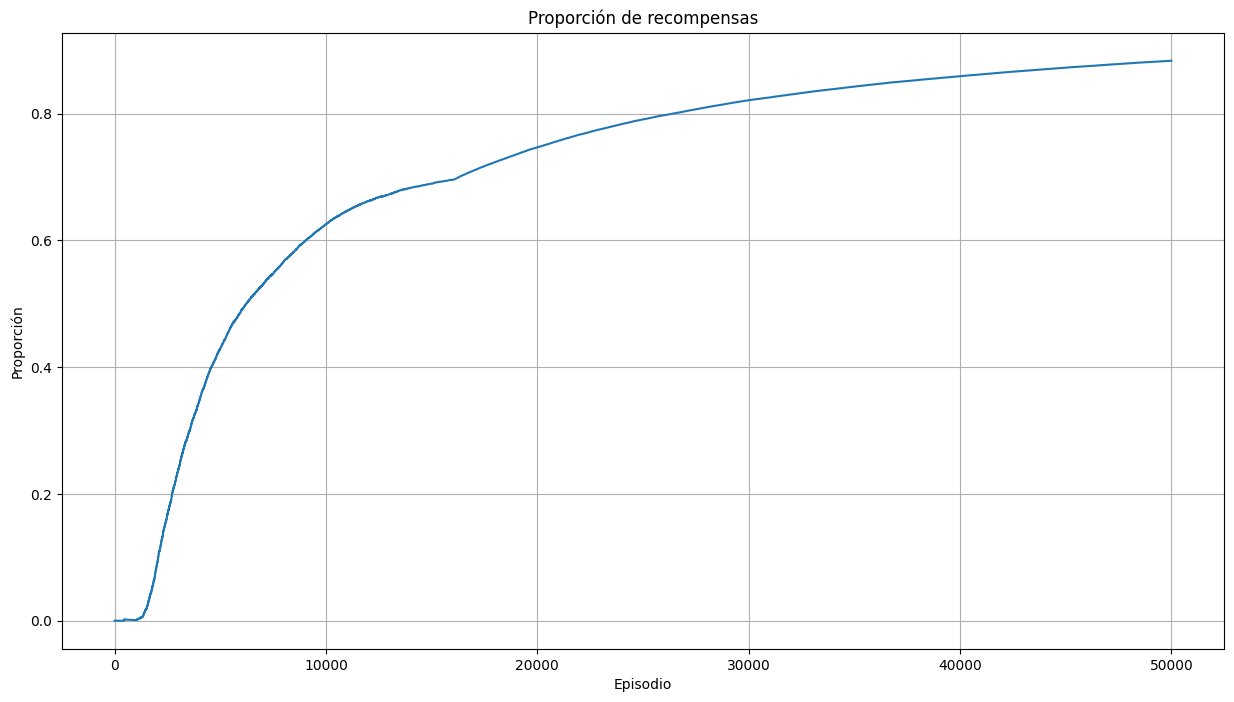

Máxima proporcion: 0.88362


In [75]:
#@title Proporción de aciertos por número de episodios

plot(list_stats)
print(f"Máxima proporcion: {list_stats[-1]}")

La proporción de recompensas va aumentando a lo largo de los episodios hasta alcanzar una máxima proporción de cerca del 0.9 de recompensa. Esta semilla seleccionada ha permitido un buen funcionamiento en este entorno para Monte Carlo on-policy. Sin embargo, al probar con otras semillas hemos observado que la proporción de recompensas se mantenía constante en 0, al no lograr alcanzar la meta en ningún episodio.

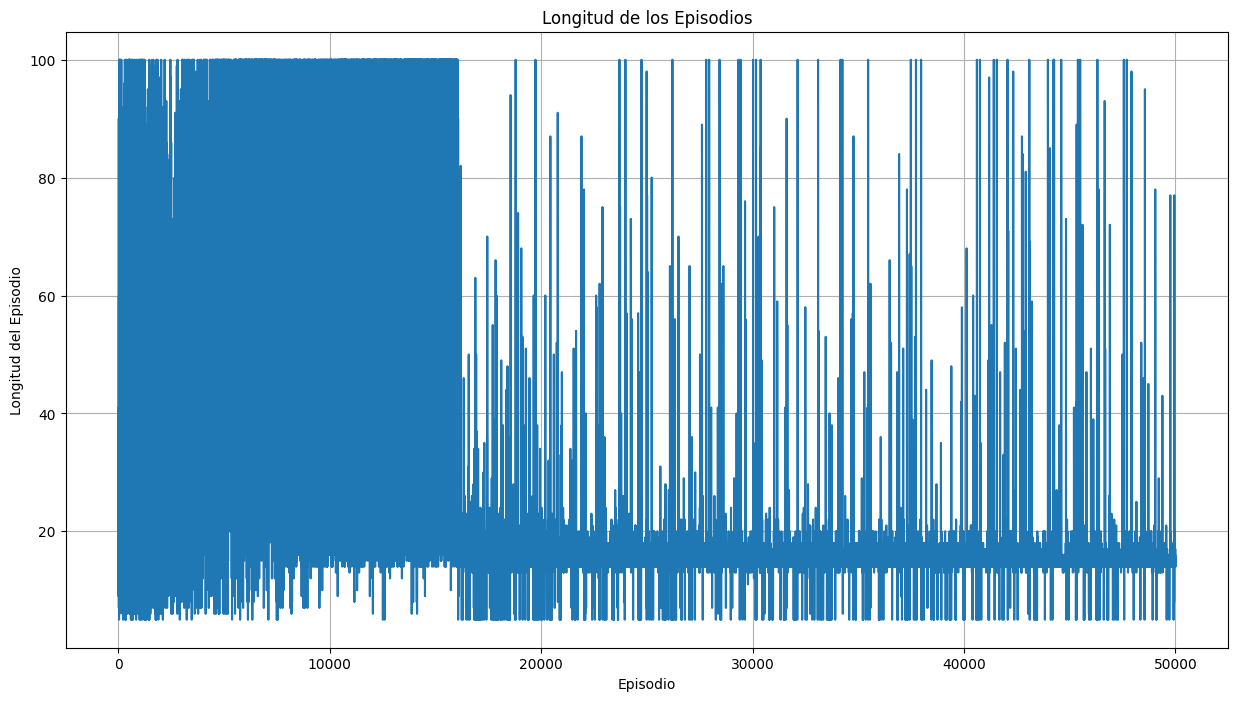

In [76]:
#@title Longitud de los episodios

plot_episode_lengths(episode_lengths)

Con el paso de los episodios, la longitud de los mismos va disminuyendo conforme el agente va aprendiendo un camino más óptimo.

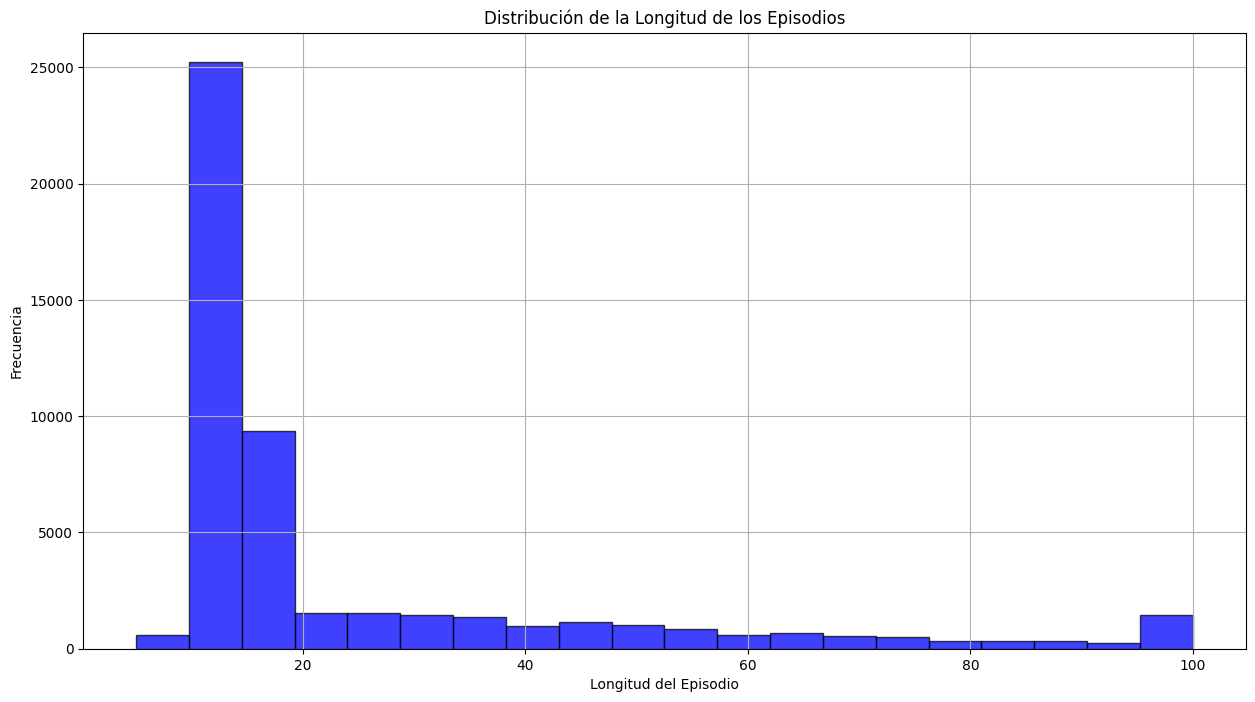

In [77]:
#@title Histograma con la longitud de los episodios

plot_episode_lengths_histogram(episode_lengths)

Efectivamente, al observar el histograma con la longitud de los episodios, vemos que rápidamente el agente consigue encontrar la meta por azar, y a partir de ahí empieza a mejorar su rendimiento, encontrando caminos más cortos hacia la meta. Gracias a que $\epsilon$ decae, comienza haciendo más exploración, con lo que logra encontrar la meta, y una vez la logra encontrar, al ir decayendo $\epsilon$, se centra más en explotar el camino óptimo que ha encontrado hasta ese momento.

Sin embargo, con otras semillas, el agente no consigue encontrar el camino hasta la meta en los primeros episodios, donde hay mayor exploración. Luego, al ir avanzando los episodios, va disminuyendo $\epsilon$, de forma que se centra en explotar un camino que no le lleva a ningún sitio, quedándose parado en la casilla inicial para no caer por ningún agujero, obteniendo una recompensa de 0 en todos los episodios.


Mostramos los valores Q para cada estado. Cada estado tienen 4 valores, que se corresponden con las 4 acciones que se pueden en cada estado.

In [78]:
# @title Tabla de valores Q
LEFT, DOWN, RIGHT, UP = 0,1,2,3
print("Valores Q para cada estado:\n", agent.Q)

Valores Q para cada estado:
 [[0.56361548 0.58830901 0.89642001 0.65893909]
 [0.35916473 0.34648742 0.89719608 0.38369963]
 [0.46777906 0.90831215 0.46025346 0.47148736]
 [0.14845361 0.63424947 0.17041199 0.1460177 ]
 [0.15588235 0.17610063 0.64423077 0.21084337]
 [0.37551867 0.73043944 0.374      0.40298507]
 [0.63119073 0.74041824 0.73124002 0.65560166]
 [0.39285714 0.78028747 0.49068323 0.38141026]
 [0.63207901 0.56610326 0.58082446 0.44717833]
 [0.19735877 0.24594156 0.22534082 0.71481684]
 [0.48754209 0.49441891 0.91512946 0.50322165]
 [0.60015004 0.         0.9376555  0.61908397]
 [0.61780105 0.61458333 0.94428987 0.70518653]
 [0.68887314 0.69409283 0.93091182 0.7018315 ]
 [0.70338668 0.76806659 0.96141538 0.74108322]
 [0.71775899 0.95732452 0.74036281 0.73111111]
 [0.14934289 0.13083049 0.61342086 0.11787072]
 [0.21026283 0.19512195 0.14994606 0.68691207]
 [0.55944518 0.12201592 0.         0.11898734]
 [0.         0.         0.         0.        ]
 [0.         0.20610687 0.71620

- También se muestra la política óptima (greedy) obtenida a partir del aprendizaje anterior.

- Cada estado tienen 4 valores, pero todos son 0 menos 1. Es decir, en cada estado se aplica de manera determinística una única acción.

*TODO:* Mostrar de forma gráfica el escenario.

In [79]:
# @title Política final
LEFT, DOWN, RIGHT, UP = 0,1,2,3
greedy_policy = GreedyFromQPolicy(env8, agent.Q)
pi = greedy_policy.compute_policy_matrix()
states, actions = greedy_policy.new_episode()

print("Política óptima obtenida\n\n", pi, f"\n\n Acciones {actions} \n\n Para el siguiente grid\n", env8.render())
print()

Política óptima obtenida

 [[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]] 

 Acciones 

In [80]:
# @title Simulaciones en vídeo
import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo

# Crear el entorno
render = "rgb_array"
env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False, render_mode=render) # render_mode "rgb_array" es necesario para RecordVideo
env._max_episode_steps = 1000  # Cambiar el límite de pasos
env = FrozenLakeCustomRewards(env)

# Solo grabamos 10 episodios, por ejemplo
trigger = lambda episode_id: episode_id < 10  # Graba solo los primeros 10 episodios

# Aplica el wrapper RecordVideo para grabar vídeos
env = gym.wrappers.RecordVideo(
    env,
    video_folder=video_folder,
    episode_trigger=trigger,  # Graba solo los primeros 10 episodios
)

num_episodes = 10 # Número de episodios a grabar
#observation, info = env.reset(seed=42)
for episode in range(num_episodes):
    observation, info = env.reset(seed = seed)
    episode_over = False
    while not episode_over:

        # Renderiza el frame actual, esto lo guardará en el archivo de video.
        env.render()

        # El agente elige la acción usando la política entrenada
        action = agent.get_action(observation)

        # Ejecuta un paso en el entorno con la acción seleccionada.
        # Obtiene la siguiente observación, la recompensa,
        # y si el episodio ha terminado (terminated) o ha sido truncado (truncated).
        observation, reward, terminated, truncated, info = env.step(action)

        # Verifica si el episodio ha terminado, ya sea por terminación o truncamiento.
        episode_over = terminated or truncated


env.close() # Importante cerrar el entorno, ¡esto finaliza la grabación de vídeo!
print(f"Grabación de episodios completada. Vídeos guardados en la carpeta '{video_folder}'")

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Grabación de episodios completada. Vídeos guardados en la carpeta 'videos'


In [81]:
latest_file = get_latest_episode_video_file(video_folder)
print(f"Último vídeo: {latest_file}") # outputs: ./video/rl-video-episode-4.mp4
embed_video(latest_file)

Último vídeo: videos/rl-video-episode-9.mp4


El agente con esta semilla consigue encontrar un camino óptimo hasta la meta. Sin embargo, como hemos explicado, esto ha sido solo por azar, pero al hacer prueba con otras semillas, hemos podido comprobar que el personaje se quedaba parado en la primera casilla, ya que de esta forma al menos obtiene recompensa $0$ al no caer por ningún agujero, lo cual le proporcionaría una recompensa negativa.

### **4.3 Nuevo experimento en el escenario 8x8**

Puesto que hemos observado que la anterior configuración no es muy robusta en general, al probar con distintas semillas, hemos considerado oportuno hacer ciertas modificaciones en el entorno, como aumentar el límite de pasos, y modificar las recompensas gracias a un wrapper. Más concretamente, definimos:

 - `hole_penalty`: penalización por caer por un agujero.
 - `step_penalty`: penalización por dar un paso sin llegar a la meta.
 - `goal_reward`: recompensa por llegar a la meta.

In [82]:
#@title **Modificación del límite de pasos**

env8._max_episode_steps = 1000  # Cambiar el límite de pasos

In [94]:
#@title **Modificación de las recompensas del entorno**

env8 = FrozenLakeCustomRewards(env8, hole_penalty=-1000, step_penalty=-0.1, goal_reward=100.0)

In [95]:
# @title **Aprendizaje**
agent = AgentMCOnPolicyAllVisits(env8, epsilon=1, decay=True, discount_factor=1)
agent.train(num_episodes=50000)

# Estadísticos
list_stats, episode_lengths = agent.get_stats()

 10%|█         | 5019/50000 [00:21<06:14, 120.25it/s]

success: -590.8010059999997, epsilon: 0.19996000799840033


 20%|██        | 10003/50000 [01:52<18:24, 36.21it/s]

success: -359.63140599999923, epsilon: 0.0999900009999


 30%|███       | 15092/50000 [02:34<01:11, 486.17it/s]

success: -245.38349666669714, epsilon: 0.06666222251849876


 40%|████      | 20123/50000 [02:42<00:44, 665.75it/s]

success: -178.39381200005556, epsilon: 0.04999750012499375


 50%|█████     | 25103/50000 [02:51<00:36, 683.48it/s]

success: -133.79223120007404, epsilon: 0.03999840006399744


 60%|██████    | 30106/50000 [02:59<00:40, 495.32it/s]

success: -102.70322133342158, epsilon: 0.033332222259258026


 70%|███████   | 35086/50000 [03:07<00:20, 711.46it/s]

success: -79.36317314295702, epsilon: 0.02857061226822091


 80%|████████  | 40078/50000 [03:16<00:16, 603.79it/s]

success: -61.15064975010919, epsilon: 0.02499937501562461


 90%|█████████ | 45067/50000 [03:24<00:10, 474.85it/s]

success: -46.95327000011717, epsilon: 0.02222172840603542


100%|██████████| 50000/50000 [03:32<00:00, 235.57it/s]


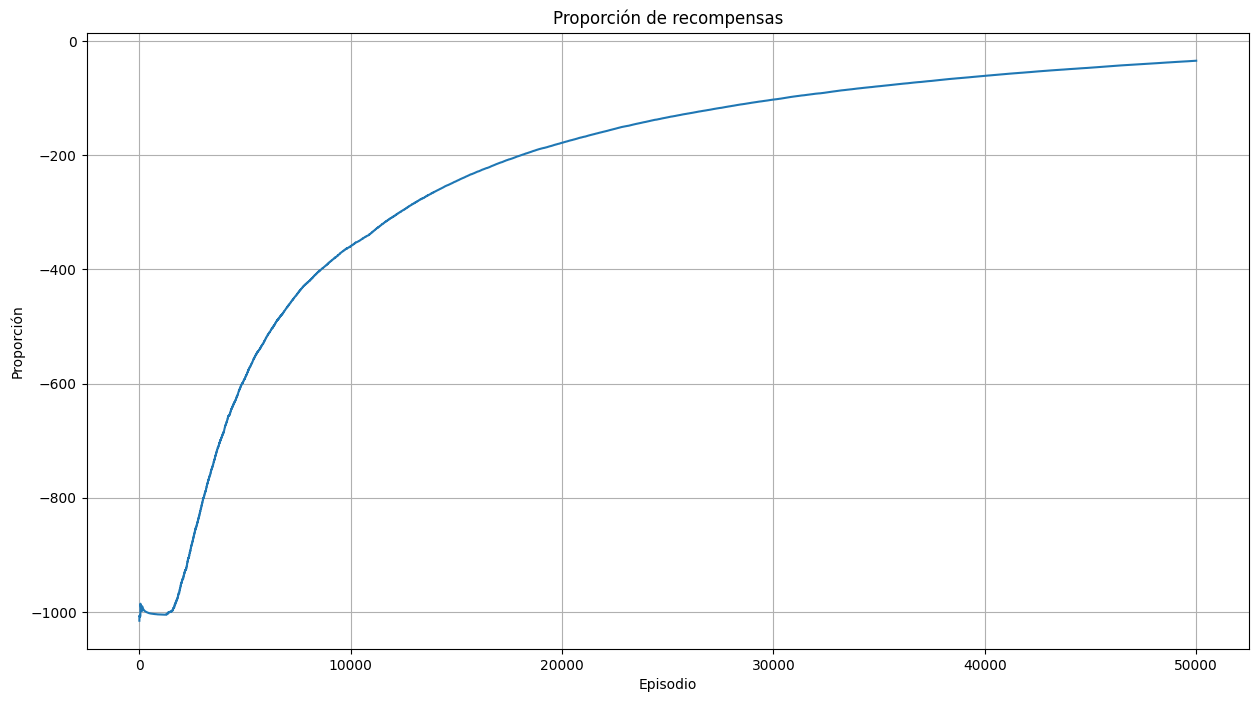

Máxima proporcion: -34.71842460010488


In [96]:
#@title **Proporción de aciertos por número de episodios**

plot(list_stats)
print(f"Máxima proporcion: {list_stats[-1]}")

Las recompensas aumentan a lo largo de los episodios, aunque en este caso son algo peores que en el escenario anterior. Sin embargo, hemos observado que esta nueva configuración es algo más robusta que la anterior al cambiar de semilla.

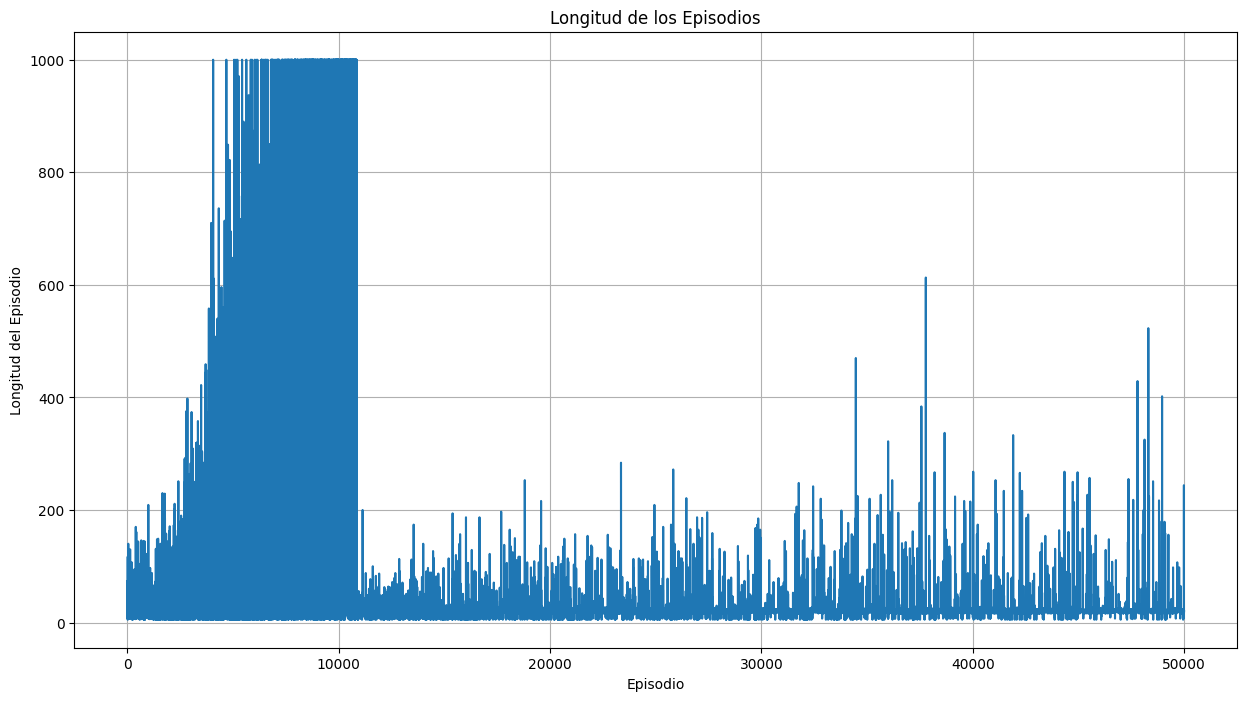

In [97]:
#@title **Longitud de los episodios**

plot_episode_lengths(episode_lengths)

Al principio, la longitud de los episodios es bastante grande, aunque a partir de los 10000 episodios aproximadamente, disminuye y se estabiliza en una longitud mucho menor.

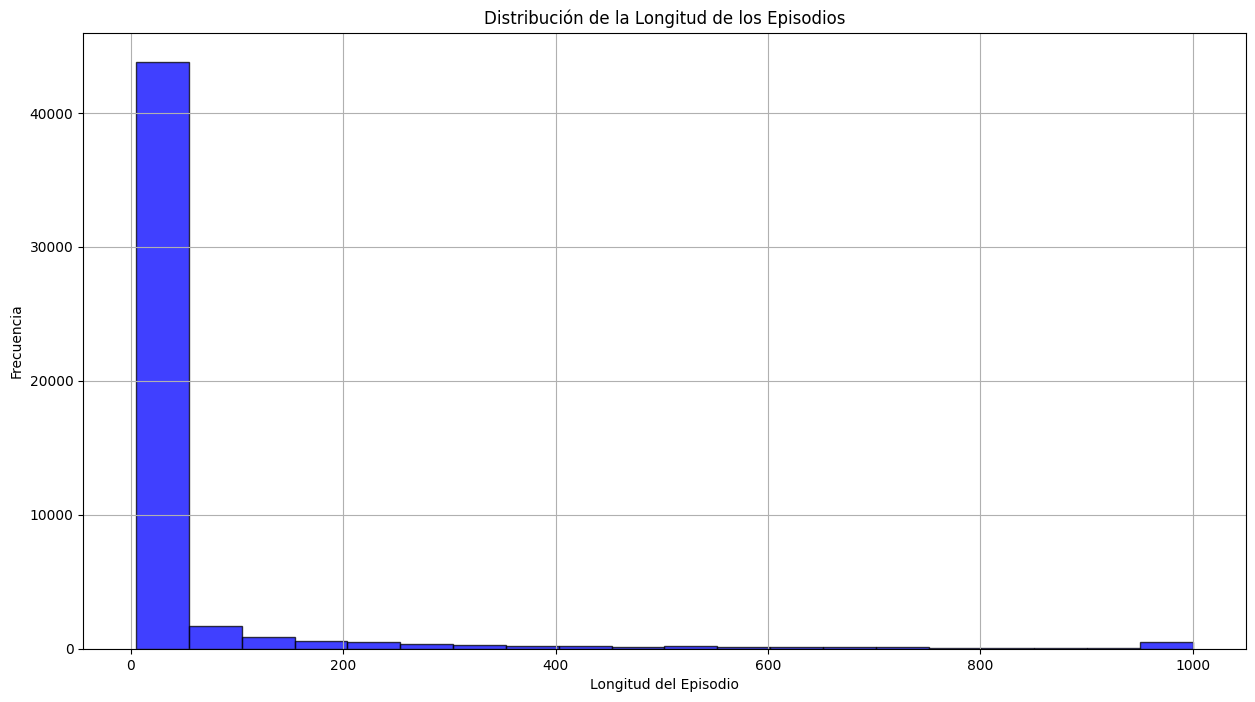

In [98]:
#@title **Histograma con la longitud de los episodios**

plot_episode_lengths_histogram(episode_lengths)

La mayoría de los episodios son bastante cortos, como se puede observar en el histograma anterior. Esto es posible que se deba a que el agente está favoreciendo tirarse por un agujero cercano a la casilla de salida en muchos de los episodios, tal vez porque le cuesta encontrar la meta, y así por lo menos evita la pérdida por paso sin llegar a la meta. Esto parece indicar que el algoritmo Monte Carlo on-policy no es demasiado robusto para este tipo de problemas, ni siquiera cuando se modifican las recompensas del entorno.

In [99]:
# @title **Tabla de valores Q**
LEFT, DOWN, RIGHT, UP = 0,1,2,3
print("Valores Q para cada estado:\n", agent.Q)

Valores Q para cada estado:
 [[ -702.1521736    -44.05557278  -694.58187915  -697.78590088]
 [ -950.51467099  -578.69962107  -952.29201635  -955.77604377]
 [ -908.93487445  -934.33207681  -349.24789062  -904.07215478]
 [ -397.57178093  -395.7205384     32.73828007  -348.00629812]
 [ -260.49498628    35.44238749  -300.79574312  -283.7352693 ]
 [ -214.31115798  -246.51988809    30.11754278  -190.35226033]
 [ -133.14920465   -15.60789439  -139.60369112  -128.29167369]
 [  -68.53745467   -70.26544628   -52.62251153   -72.48018987]
 [ -630.18264803   -28.24248471  -604.0357877   -644.77743663]
 [ -892.78870699  -899.46945802  -294.30590359  -867.89339979]
 [ -446.2480056   -523.61179095    11.35416717  -399.36942922]
 [ -308.54193756 -1000.          -311.89545863    35.01420264]
 [ -265.33838552  -294.17161959    39.24395036  -223.07166195]
 [ -224.92736213  -218.53325946  -199.23502343    35.28571392]
 [ -132.06572383   -96.15604614   -14.28357502  -127.99427915]
 [ -118.7607543     60.376

In [100]:
# @title **Política final**
LEFT, DOWN, RIGHT, UP = 0,1,2,3
greedy_policy = GreedyFromQPolicy(env8, agent.Q)
pi = greedy_policy.compute_policy_matrix()
states, actions = greedy_policy.new_episode()

print("Política óptima obtenida\n\n", pi, f"\n\n Acciones {actions} \n\n Para el siguiente grid\n", env8.render())
print()

Política óptima obtenida

 [[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]] 

 Acciones 

In [101]:
# @title Simulaciones en vídeo
import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo

# Crear el entorno
render = "rgb_array"
env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False, render_mode=render) # render_mode "rgb_array" es necesario para RecordVideo
env._max_episode_steps = 1000  # Cambiar el límite de pasos
env = FrozenLakeCustomRewards(env)

# Solo grabamos 10 episodios, por ejemplo
trigger = lambda episode_id: episode_id < 10  # Graba solo los primeros 10 episodios

# Aplica el wrapper RecordVideo para grabar vídeos
env = gym.wrappers.RecordVideo(
    env,
    video_folder=video_folder,
    episode_trigger=trigger,  # Graba solo los primeros 10 episodios
)

num_episodes = 10 # Número de episodios a grabar
#observation, info = env.reset(seed=42)
for episode in range(num_episodes):
    observation, info = env.reset(seed = seed)
    episode_over = False
    while not episode_over:

        # Renderiza el frame actual, esto lo guardará en el archivo de video.
        env.render()

        # El agente elige la acción usando la política entrenada
        action = agent.get_action(observation)

        # Ejecuta un paso en el entorno con la acción seleccionada.
        # Obtiene la siguiente observación, la recompensa,
        # y si el episodio ha terminado (terminated) o ha sido truncado (truncated).
        observation, reward, terminated, truncated, info = env.step(action)

        # Verifica si el episodio ha terminado, ya sea por terminación o truncamiento.
        episode_over = terminated or truncated


env.close() # Importante cerrar el entorno, ¡esto finaliza la grabación de vídeo!
print(f"Grabación de episodios completada. Vídeos guardados en la carpeta '{video_folder}'")

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Grabación de episodios completada. Vídeos guardados en la carpeta 'videos'


In [102]:
latest_file = get_latest_episode_video_file(video_folder)
print(f"Último vídeo: {latest_file}") # outputs: ./video/rl-video-episode-4.mp4
embed_video(latest_file)

Último vídeo: videos/rl-video-episode-9.mp4


El personaje consigue llegar a la meta, aunque el camino que sigue no es de los más óptimos, ya que da algunas vueltas por el camino.

### **4.4 Análisis de Resultados**

- En los dos entornos (4x4 y 8x8), el agente comienza con un conocimiento muy limitado, pero gradualmente mejora su desempeño a medida que avanza en los episodios. Este comportamiento se puede observar en el gráfico de la proporción de recompensas, que aumenta con el tiempo.
- En el entorno 4x4, la máxima proporción de éxito alcanzada fue 0.522, mientras que en el entorno 8x8, la máxima alcanzada fue 0.914. Esto refleja que el agente aprendió a optimizar su estrategia en un entorno más complejo.
- La política óptima obtenida muestra las acciones recomendadas por el agente en cada estado del entorno. En el entorno 8x8, la política es más compleja debido a la mayor cantidad de estados y la dificultad del entorno, por lo que modificar las recompensas con el uso de un wrapper nos ha sido de gran ayuda.


## **5. Monte Carlo off-policy**

   - En esta sección, el algoritmo de Monte Carlo off-policy con la política epsilon-soft se ejecuta para el entorno de 8x8 de FrozenLake sin resbalar, con las recompensas modificadas, similar a como hemos hecho en el apartado anterior.
   
   - En ambos casos se realiza un entrenamiento con un número determinado de episodios (50000 en concreto)

   - Además el epsilon tiene decaimiento de acuerdo a la expresión: $\epsilon = min(1.0, 1000.0/(t+1))$

   - Durante el entrenamiento hay una visualización de la proporción de recompensas obtenidas a lo largo del entrenamiento.

   - Junto a dicho volcado se muestra gráficamente la proporción de recompensas obtenidas.

   - También se hace un volcado de los valores Q de cada estado, donde se muestra cómo el agente valora diferentes acciones en distintos estados del entorno, lo que puede interpretarse como su conocimiento sobre las mejores estrategias para alcanzar la meta sin caer en los agujeros.

   - Además, se muestra la política óptima derivada de los valores Q. Esta política es la que el agente seguiría si tuviera que elegir siempre la acción que maximiza su recompensa esperada.

   

In [104]:
env8 = gym.make(name, is_slippery=False, map_name="8x8", render_mode="ansi") # No resbaladizo para entender mejor los resultados.
env8.reset(seed=seed)

(0, {'prob': 1})

In [ ]:
#@title **Modificación del límite de pasos**

env8._max_episode_steps = 1000  # Cambiar el límite de pasos

In [106]:
#@title **Modificación de las recompensas del entorno**

env8 = FrozenLakeCustomRewards(env8, hole_penalty=-100, step_penalty=-0.001, goal_reward=100.0)

In [107]:
# @title **Aprendizaje**
agent = AgentMCOffPolicyAllVisits(env8, epsilon=1, decay=True, discount_factor=0.9)
agent.train(num_episodes=50000)

# Estadísticos
list_stats, episode_lengths = agent.get_stats()

 10%|█         | 5064/50000 [00:12<01:35, 468.35it/s]

success: -35.79235966049777, epsilon: 0.19996000799840033


 20%|██        | 10055/50000 [00:25<01:40, 399.17it/s]

success: -2.8949154299826585, epsilon: 0.0999900009999


 30%|███       | 15073/50000 [00:42<01:46, 326.61it/s]

success: 8.26608790584613, epsilon: 0.06666222251849876


 40%|████      | 20063/50000 [00:58<01:19, 377.80it/s]

success: 13.82307652687824, epsilon: 0.04999750012499375


 50%|█████     | 25064/50000 [01:13<01:12, 345.90it/s]

success: 17.09438854995718, epsilon: 0.03999840006399744


 60%|██████    | 30039/50000 [01:30<00:59, 334.35it/s]

success: 19.07700977046006, epsilon: 0.033332222259258026


 70%|███████   | 35043/50000 [01:47<00:44, 338.98it/s]

success: 20.46069512097352, epsilon: 0.02857061226822091


 80%|████████  | 40051/50000 [02:03<00:31, 318.90it/s]

success: 21.4405940629624, epsilon: 0.02499937501562461


 90%|█████████ | 45071/50000 [02:19<00:14, 340.28it/s]

success: 22.210542833683817, epsilon: 0.02222172840603542


100%|██████████| 50000/50000 [02:36<00:00, 318.53it/s]


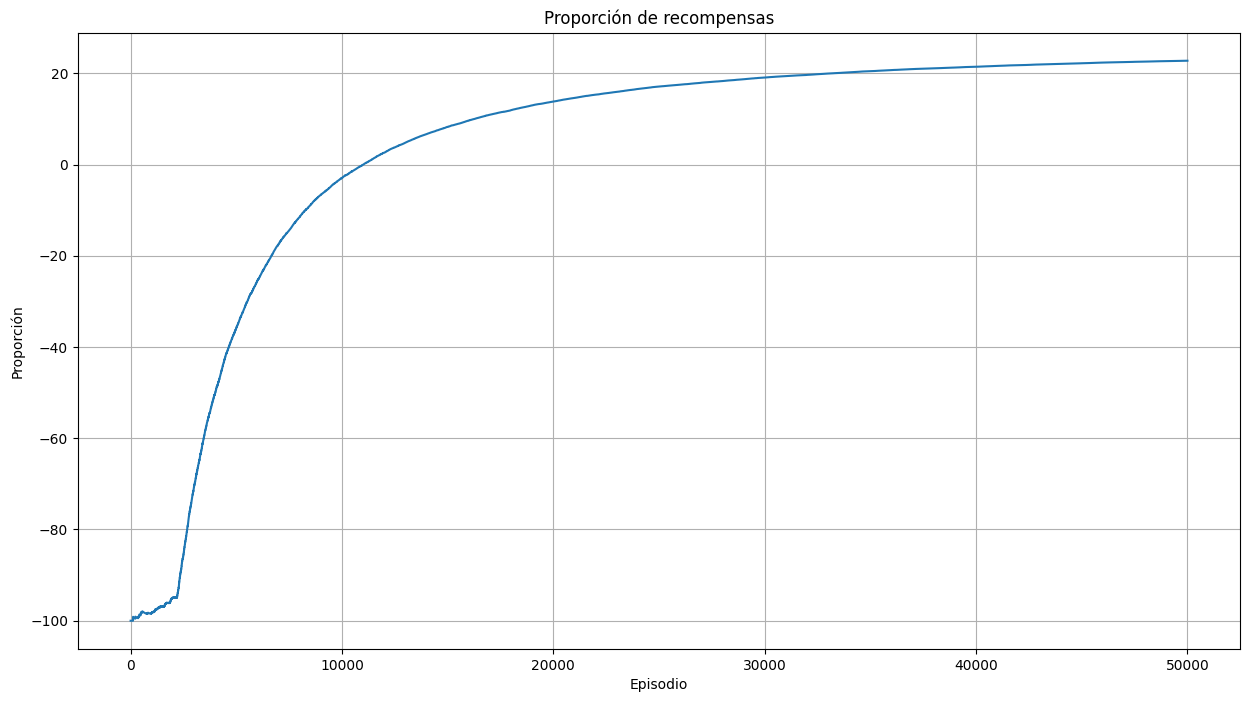

Máxima proporcion: 22.76606411984316


In [108]:
#@title **Proporción de aciertos por número de episodios**

plot(list_stats)
print(f"Máxima proporcion: {list_stats[-1]}")

Observando la gráfica para la proporción de recompensas con Monte Carlo off-policy, esta parece mejorar con respecto a Monte Carlo on-policy, indicando que la estrategia de usar dos políticas, una política objetivo y una de comportamiento, ayuda a mejorar el rendimiento del algoritmo.

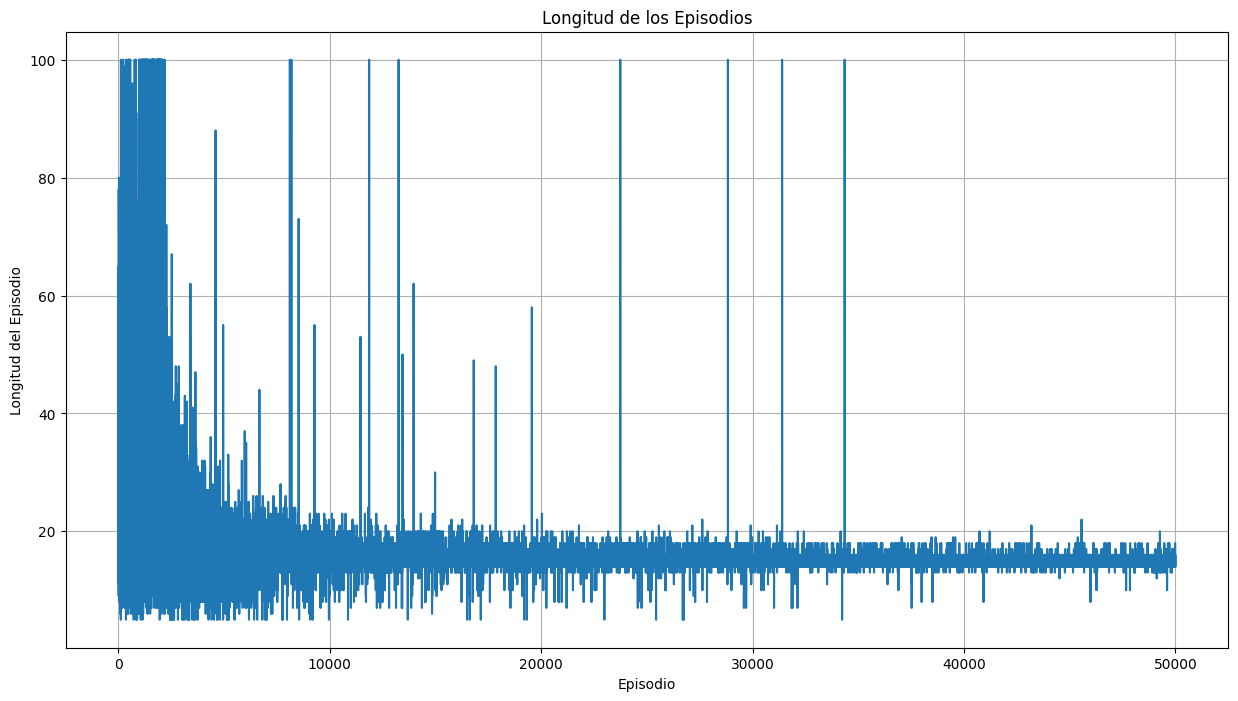

In [109]:
#@title **Longitud de los episodios**

plot_episode_lengths(episode_lengths)

Al principio, los episodios son algo más largos, aunque en este caso hemos dejado una longitud máxima de 100 pasos por episodio, y aun así se han obtenido resultados relativamente buenos. Con otros algoritmos es necesario aumentar más el límite de pasos para que logre aprender correctamente, pero en este caso no ha sido necesario.

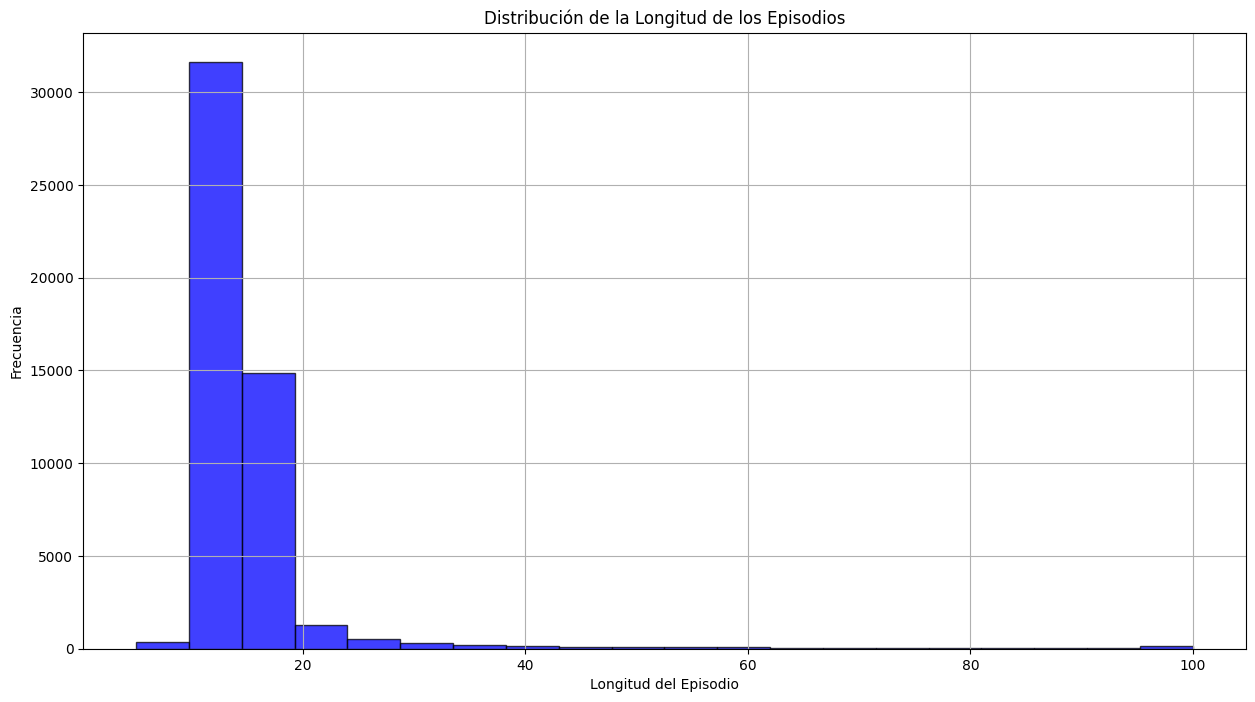

In [110]:
#@title **Histograma con la longitud de los episodios**

plot_episode_lengths_histogram(episode_lengths)

Efectivamente, la mayoría de episodios tienen una longitud de unos 10 o 15 pasos, y además hay muy pocos episodios que alcancen el número máximo de pasos.

In [111]:
# @title **Tabla de valores Q**
LEFT, DOWN, RIGHT, UP = 0,1,2,3
print("Valores Q para cada estado:\n", agent.Q)

Valores Q para cada estado:
 [[ 2.27506421e+01  2.49515704e+01  2.54101480e+01  2.28378573e+01]
 [ 2.28434340e+01  2.81941657e+01  2.82357779e+01  2.53826255e+01]
 [ 2.53862358e+01  3.13336050e+01  3.13728614e+01  2.82357779e+01]
 [ 2.82357779e+01  3.48095317e+01  3.48613308e+01  3.13741977e+01]
 [ 3.13741977e+01  3.79540616e+01  3.87359231e+01  3.48613308e+01]
 [ 3.48613308e+01  4.30410257e+01  4.30410257e+01  3.87359231e+01]
 [ 3.83055463e+01  4.78244730e+01  4.78244730e+01  4.30410257e+01]
 [ 4.17494652e+01  5.31394144e+01  4.54899481e+01  4.78244730e+01]
 [ 2.03886417e+01 -1.40853835e-03  2.81264879e+01  2.16729382e+01]
 [ 2.12136184e+01  2.07323706e+01  3.03912275e+01  2.34243187e+01]
 [ 2.68353478e+01  2.77059883e+01  3.43937971e+01  2.80692755e+01]
 [ 3.13741977e+01 -1.00000000e+02  3.82717838e+01  3.13741977e+01]
 [ 3.15842211e+01  4.30410257e+01  4.30410257e+01  3.47707863e+01]
 [ 3.73257181e+01  4.74423602e+01  4.78244730e+01  3.87359231e+01]
 [ 4.30410257e+01  5.25674752e+01

In [112]:
# @title **Política final**
LEFT, DOWN, RIGHT, UP = 0,1,2,3
greedy_policy = GreedyFromQPolicy(env8, agent.Q)
pi = greedy_policy.compute_policy_matrix()
states, actions = greedy_policy.new_episode()

print("Política óptima obtenida\n\n", pi, f"\n\n Acciones {actions} \n\n Para el siguiente grid\n", env8.render())
print()

Política óptima obtenida

 [[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]] 

 Acciones 

In [117]:
# @title Simulaciones en vídeo
import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo

# Crear el entorno
render = "rgb_array"
env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False, render_mode=render) # render_mode "rgb_array" es necesario para RecordVideo
env._max_episode_steps = 1000  # Cambiar el límite de pasos
env = FrozenLakeCustomRewards(env)

# Solo grabamos 10 episodios, por ejemplo
trigger = lambda episode_id: episode_id < 10  # Graba solo los primeros 10 episodios

# Aplica el wrapper RecordVideo para grabar vídeos
env = gym.wrappers.RecordVideo(
    env,
    video_folder=video_folder,
    episode_trigger=trigger,  # Graba solo los primeros 10 episodios
)

num_episodes = 10 # Número de episodios a grabar
#observation, info = env.reset(seed=42)
for episode in range(num_episodes):
    observation, info = env.reset(seed = seed)
    episode_over = False
    while not episode_over:

        # Renderiza el frame actual, esto lo guardará en el archivo de video.
        env.render()

        # El agente elige la acción usando la política entrenada
        action = agent.get_greedy_action(observation)

        # Ejecuta un paso en el entorno con la acción seleccionada.
        # Obtiene la siguiente observación, la recompensa,
        # y si el episodio ha terminado (terminated) o ha sido truncado (truncated).
        observation, reward, terminated, truncated, info = env.step(action)

        # Verifica si el episodio ha terminado, ya sea por terminación o truncamiento.
        episode_over = terminated or truncated


env.close() # Importante cerrar el entorno, ¡esto finaliza la grabación de vídeo!
print(f"Grabación de episodios completada. Vídeos guardados en la carpeta '{video_folder}'")

Grabación de episodios completada. Vídeos guardados en la carpeta 'videos'


In [118]:
latest_file = get_latest_episode_video_file(video_folder)
print(f"Último vídeo: {latest_file}") # outputs: ./video/rl-video-episode-4.mp4
embed_video(latest_file)

Último vídeo: videos/rl-video-episode-9.mp4


En la simulación del vídeo se consigue encontrar un camino óptimo hasta la meta.

## **6. SARSA**

   - En esta sección, el algoritmo de SARSA con la política epsilon-soft se ejecuta para el entorno de 8x8 de FrozenLake sin resbalar, con las recompensas ya modificadas en el apartado anterior.
   
   - En ambos casos se realiza un entrenamiento con un número determinado de episodios (50000 en concreto)

   - Además el epsilon tiene decaimiento de acuerdo a la expresión: $\epsilon = min(1.0, 1000.0/(t+1))$

   - Durante el entrenamiento hay una visualización de la proporción de recompensas obtenidas a lo largo del entrenamiento.

   - Junto a dicho volcado se muestra gráficamente la proporción de recompensas obtenidas.

   - También se hace un volcado de los valores Q de cada estado, donde se muestra cómo el agente valora diferentes acciones en distintos estados del entorno, lo que puede interpretarse como su conocimiento sobre las mejores estrategias para alcanzar la meta sin caer en los agujeros.

   - Además, se muestra la política óptima derivada de los valores Q. Esta política es la que el agente seguiría si tuviera que elegir siempre la acción que maximiza su recompensa esperada.

   

In [128]:
env8 = gym.make(name, is_slippery=False, map_name="8x8", render_mode="ansi") # No resbaladizo para entender mejor los resultados.
env8.reset(seed=seed)

(0, {'prob': 1})

In [129]:
#@title **Modificación del límite de pasos**

env8._max_episode_steps = 1000  # Cambiar el límite de pasos

In [130]:
#@title **Modificación de las recompensas del entorno**

env8 = FrozenLakeCustomRewards(env8, hole_penalty=-100, step_penalty=-0.001, goal_reward=100)

In [131]:
# @title **Aprendizaje**
agent = AgentSARSA(env8, epsilon=1, decay=True, discount_factor=0.9, alpha=0.7)
agent.train(num_episodes=50000)

# Estadísticos
list_stats, episode_lengths = agent.get_stats()

 10%|▉         | 4994/50000 [01:54<07:10, 104.55it/s]

success: -76.07510179999981, epsilon: 0.19996000799840033


 20%|██        | 10002/50000 [06:45<41:27, 16.08it/s]

success: -48.418230799999876, epsilon: 0.0999900009999


 30%|███       | 15004/50000 [12:21<39:38, 14.71it/s]

success: -35.960747599999856, epsilon: 0.06666222251849876


 40%|████      | 20003/50000 [18:15<41:53, 11.93it/s]

success: -29.08446634999994, epsilon: 0.04999750012499375


 50%|█████     | 25038/50000 [24:08<04:52, 85.48it/s]

success: -23.92755335999997, epsilon: 0.03999840006399744


 60%|██████    | 30003/50000 [29:42<25:57, 12.84it/s]

success: -20.166494233333378, epsilon: 0.033332222259258026


 70%|███████   | 35003/50000 [35:30<16:04, 15.55it/s]

success: -17.348937371428637, epsilon: 0.02857061226822091


 80%|████████  | 40004/50000 [40:51<14:16, 11.67it/s]

success: -14.878101550000112, epsilon: 0.02499937501562461


 90%|█████████ | 45002/50000 [46:12<07:30, 11.10it/s]

success: -12.950905022222443, epsilon: 0.02222172840603542


100%|██████████| 50000/50000 [51:56<00:00, 16.05it/s]


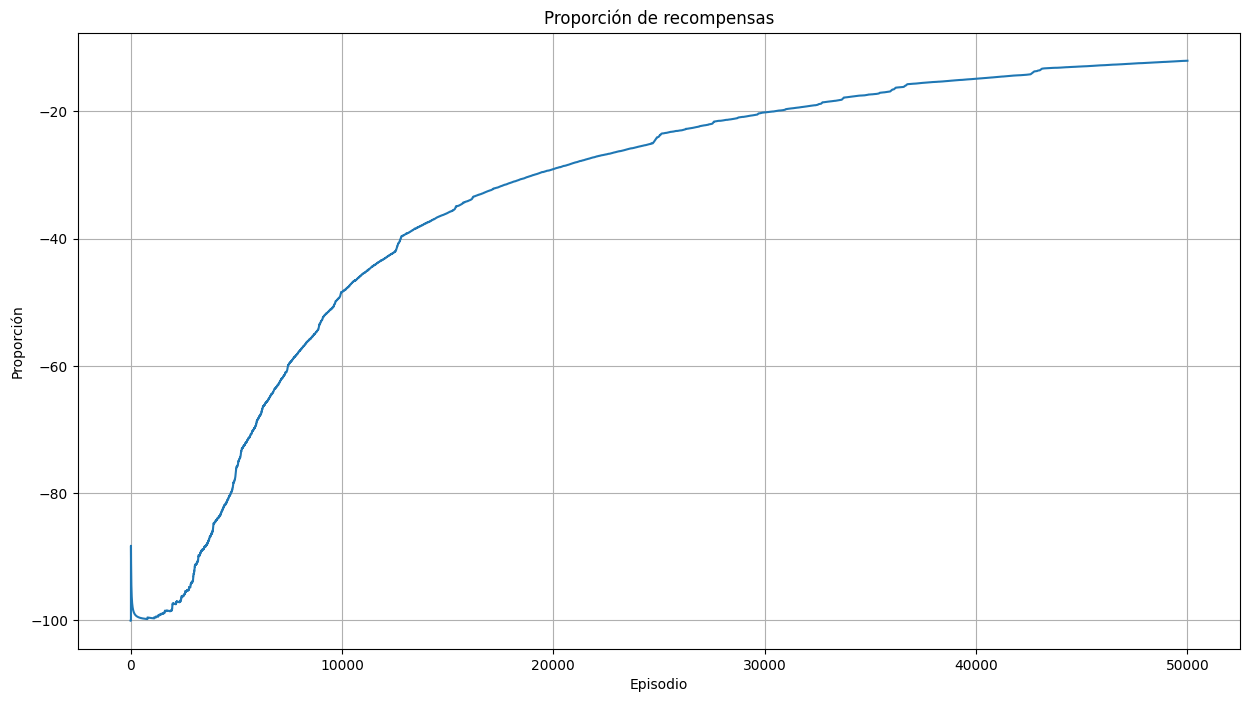

Máxima proporcion: -12.0462812200002


In [132]:
#@title **Proporción de aciertos por número de episodios**

plot(list_stats)
print(f"Máxima proporcion: {list_stats[-1]}")

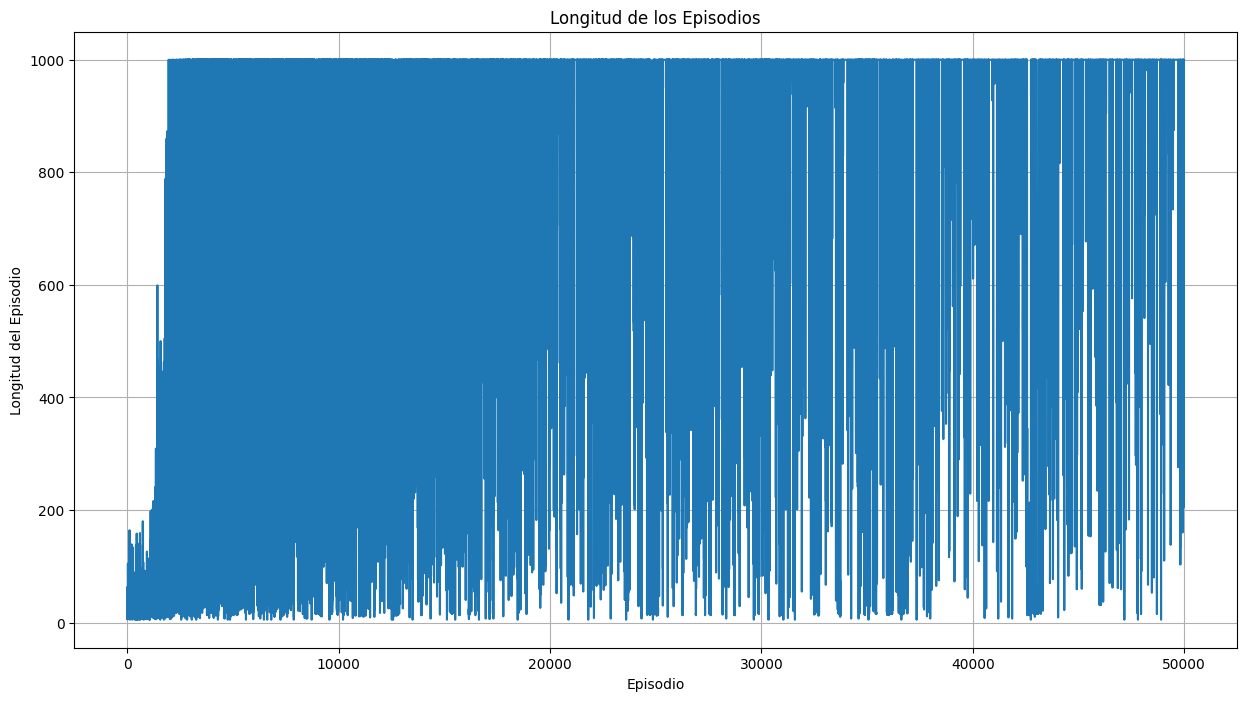

In [133]:
#@title **Longitud de los episodios**

plot_episode_lengths(episode_lengths)

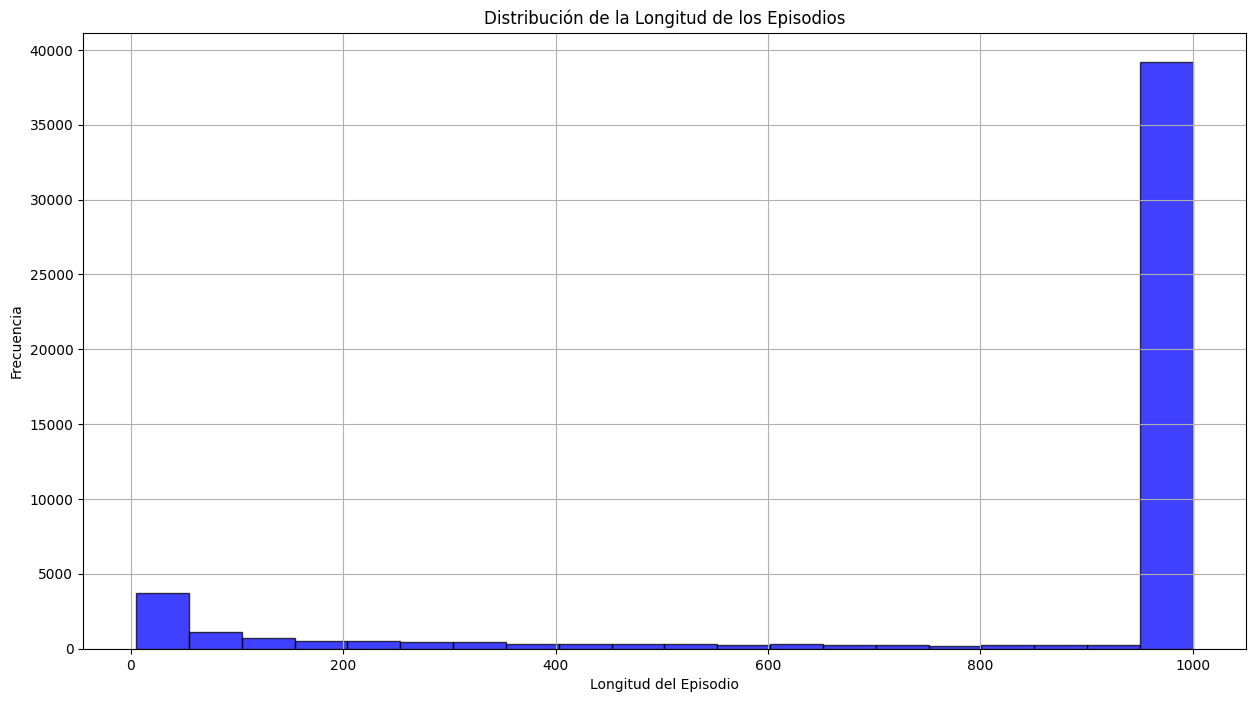

In [134]:
#@title **Histograma con la longitud de los episodios**

plot_episode_lengths_histogram(episode_lengths)

In [135]:
# @title **Tabla de valores Q**
LEFT, DOWN, RIGHT, UP = 0,1,2,3
print("Valores Q para cada estado:\n", agent.Q)

Valores Q para cada estado:
 [[-8.57361712e-01 -4.55655139e-01 -3.81084336e-02 -1.47312160e-01]
 [-2.80775878e-01 -2.66075259e-01 -3.53857163e-02 -2.83771940e-01]
 [-7.78420029e-01 -6.22994598e+00 -2.19906608e-02 -4.88077069e-01]
 [-3.11153787e+00 -1.89096572e+01 -2.78598635e-02 -3.96965177e+01]
 [-1.48368371e-01 -2.28076437e+00 -3.06773084e-02 -2.17658707e-01]
 [-1.44387120e+00 -1.12150737e-02 -1.08264276e-01 -3.01068364e+00]
 [-4.07236837e-03 -1.09356723e-01 -2.22082035e-01 -6.53401528e-02]
 [-2.83058426e-01 -1.75958726e-01 -3.45184324e-01 -3.34439042e-01]
 [-6.53538770e-01 -9.05007346e-01 -3.54074061e-01 -1.03266198e-01]
 [-9.37277800e-01 -7.19577502e-01 -1.19617353e+01 -2.17003157e-01]
 [-3.01372212e-01 -3.61468604e+00 -5.77545575e+00 -9.99542625e+00]
 [-5.90900068e-01 -1.00000000e+02 -2.50549512e+01 -2.56140635e-02]
 [-2.07795755e-02 -1.74420231e+00 -3.62041495e+00 -1.43315095e+00]
 [-2.75489308e-02 -5.70982726e+00 -1.11883218e-02 -1.19386952e-01]
 [-3.60403330e+00 -1.28326206e-01

In [136]:
# @title **Política final**
LEFT, DOWN, RIGHT, UP = 0,1,2,3
greedy_policy = GreedyFromQPolicy(env8, agent.Q)
pi = greedy_policy.compute_policy_matrix()
states, actions = greedy_policy.new_episode()

print("Política óptima obtenida\n\n", pi, f"\n\n Acciones {actions} \n\n Para el siguiente grid\n", env8.render())
print()

Política óptima obtenida

 [[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]] 

 Acciones 

In [137]:
# @title Simulaciones en vídeo
import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo

# Crear el entorno
render = "rgb_array"
env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False, render_mode=render) # render_mode "rgb_array" es necesario para RecordVideo
env._max_episode_steps = 1000  # Cambiar el límite de pasos
env = FrozenLakeCustomRewards(env)

# Solo grabamos 10 episodios, por ejemplo
trigger = lambda episode_id: episode_id < 10  # Graba solo los primeros 10 episodios

# Aplica el wrapper RecordVideo para grabar vídeos
env = gym.wrappers.RecordVideo(
    env,
    video_folder=video_folder,
    episode_trigger=trigger,  # Graba solo los primeros 10 episodios
)

num_episodes = 10 # Número de episodios a grabar
#observation, info = env.reset(seed=42)
for episode in range(num_episodes):
    observation, info = env.reset(seed = seed)
    episode_over = False
    while not episode_over:

        # Renderiza el frame actual, esto lo guardará en el archivo de video.
        env.render()

        # El agente elige la acción usando la política entrenada
        action = agent.get_action(observation)

        # Ejecuta un paso en el entorno con la acción seleccionada.
        # Obtiene la siguiente observación, la recompensa,
        # y si el episodio ha terminado (terminated) o ha sido truncado (truncated).
        observation, reward, terminated, truncated, info = env.step(action)

        # Verifica si el episodio ha terminado, ya sea por terminación o truncamiento.
        episode_over = terminated or truncated


env.close() # Importante cerrar el entorno, ¡esto finaliza la grabación de vídeo!
print(f"Grabación de episodios completada. Vídeos guardados en la carpeta '{video_folder}'")

Grabación de episodios completada. Vídeos guardados en la carpeta 'videos'


In [138]:
latest_file = get_latest_episode_video_file(video_folder)
print(f"Último vídeo: {latest_file}") # outputs: ./video/rl-video-episode-4.mp4
embed_video(latest_file)

Último vídeo: videos/rl-video-episode-9.mp4


## **7. Q-Learning**

   - En esta sección, el algoritmo de Q-Learning con la política epsilon-soft se ejecuta para el entorno de 8x8 de FrozenLake sin resbalar, con las recompensas ya modificadas en el apartado anterior.
   
   - En ambos casos se realiza un entrenamiento con un número determinado de episodios (50000 en concreto)

   - Además el epsilon tiene decaimiento de acuerdo a la expresión: $\epsilon = min(1.0, 1000.0/(t+1))$

   - Durante el entrenamiento hay una visualización de la proporción de recompensas obtenidas a lo largo del entrenamiento.

   - Junto a dicho volcado se muestra gráficamente la proporción de recompensas obtenidas.

   - También se hace un volcado de los valores Q de cada estado, donde se muestra cómo el agente valora diferentes acciones en distintos estados del entorno, lo que puede interpretarse como su conocimiento sobre las mejores estrategias para alcanzar la meta sin caer en los agujeros.

   - Además, se muestra la política óptima derivada de los valores Q. Esta política es la que el agente seguiría si tuviera que elegir siempre la acción que maximiza su recompensa esperada.

   

In [ ]:
env8 = gym.make(name, is_slippery=False, map_name="8x8", render_mode="ansi") # No resbaladizo para entender mejor los resultados.
env8.reset(seed=seed)

In [ ]:
#@title **Modificación del límite de pasos**

env8._max_episode_steps = 1000  # Cambiar el límite de pasos

In [ ]:
#@title **Modificación de las recompensas del entorno**

env8 = FrozenLakeCustomRewards(env8, hole_penalty=-100, step_penalty=-0.001, goal_reward=100.0)

In [ ]:
# @title **Aprendizaje**
agent = AgentQLearning(env8, epsilon=1, decay=True, discount_factor=0.9, alpha=0.7)
agent.train(num_episodes=50000)

# Estadísticos
list_stats, episode_lengths = agent.get_stats()

In [ ]:
#@title **Proporción de aciertos por número de episodios**

plot(list_stats)
print(f"Máxima proporcion: {list_stats[-1]}")

In [ ]:
#@title **Longitud de los episodios**

plot_episode_lengths(episode_lengths)

In [ ]:
#@title **Histograma con la longitud de los episodios**

plot_episode_lengths_histogram(episode_lengths)

In [ ]:
# @title **Tabla de valores Q**
LEFT, DOWN, RIGHT, UP = 0,1,2,3
print("Valores Q para cada estado:\n", agent.Q)

In [ ]:
# @title **Política final**
LEFT, DOWN, RIGHT, UP = 0,1,2,3
greedy_policy = GreedyFromQPolicy(env8, agent.Q)
pi = greedy_policy.compute_policy_matrix()
states, actions = greedy_policy.new_episode()

print("Política óptima obtenida\n\n", pi, f"\n\n Acciones {actions} \n\n Para el siguiente grid\n", env8.render())
print()

In [ ]:
# @title Simulaciones en vídeo
import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo

# Crear el entorno
render = "rgb_array"
env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False, render_mode=render) # render_mode "rgb_array" es necesario para RecordVideo
env._max_episode_steps = 1000  # Cambiar el límite de pasos
env = FrozenLakeCustomRewards(env)

# Solo grabamos 10 episodios, por ejemplo
trigger = lambda episode_id: episode_id < 10  # Graba solo los primeros 10 episodios

# Aplica el wrapper RecordVideo para grabar vídeos
env = gym.wrappers.RecordVideo(
    env,
    video_folder=video_folder,
    episode_trigger=trigger,  # Graba solo los primeros 10 episodios
)

num_episodes = 10 # Número de episodios a grabar
#observation, info = env.reset(seed=42)
for episode in range(num_episodes):
    observation, info = env.reset(seed = seed)
    episode_over = False
    while not episode_over:

        # Renderiza el frame actual, esto lo guardará en el archivo de video.
        env.render()

        # El agente elige la acción usando la política entrenada
        action = agent.get_action(observation)

        # Ejecuta un paso en el entorno con la acción seleccionada.
        # Obtiene la siguiente observación, la recompensa,
        # y si el episodio ha terminado (terminated) o ha sido truncado (truncated).
        observation, reward, terminated, truncated, info = env.step(action)

        # Verifica si el episodio ha terminado, ya sea por terminación o truncamiento.
        episode_over = terminated or truncated


env.close() # Importante cerrar el entorno, ¡esto finaliza la grabación de vídeo!
print(f"Grabación de episodios completada. Vídeos guardados en la carpeta '{video_folder}'")

In [ ]:
latest_file = get_latest_episode_video_file(video_folder)
print(f"Último vídeo: {latest_file}") # outputs: ./video/rl-video-episode-4.mp4
embed_video(latest_file)